In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import bbknn
import igraph
from sklearn.decomposition import TruncatedSVD

import sys
sys.path.append('../../')
from pipelines import *
from parameters import *

import warnings
warnings.filterwarnings('ignore')

2022-04-15 18:28:37.942282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 18:28:37.942300: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
adata = scp.read("data/qc.h5ad")

# Dimensionality reduction of the full dataset

Until now, the analysis has been performed at each stage independently. Now we are interested in making a full integration of the data to see the transcriptomic trajectories along time.

For that, we perform a dimensionality reduction using the following pipeline:

 1. Selection of Highly Varying Genes using `seurat` flavor with the selection being the combination of the HVGs of each stage. We remove genes related with sex and cell cycle from this list.
 2. PCA, in the flavor of Truncated SD Decomposition.
 
Notice that for this embedding we do not make any kind of batch correction as it is not clear what should be the correction between stages and it does not make much sense to make a correction between samples of each batch while mantaining the rest fixed.
 
This returns us a latent space of the hole dataset.

In [3]:
#Global computation of HVGs and PCs
scp.pp.highly_variable_genes(adata,flavor=HVG_METHOD,batch_key="Stage")
adata.var.loc[:,"higly_variable"] = [not ((g in SKIP_GENES) or not hv) for g,hv in adata.var.loc[:,["Gene","highly_variable"]].values]
X = TruncatedSVD(n_components=50,random_state=0).fit_transform(adata.X[:,adata.var.loc[:,"highly_variable"].values])
        
adata.obsm["X_pca"] = X

# Paga by stages and samples

We expect that the connections between cells are more strongly connected in a causal order, being stages at close points having cells more connected than others.

We can test this making a PAGA graph. For that we perform the following process:

 1. Make a KNN neighbour graph over the reduced space mentioned above.
 2. Make PAGA graph by Stages and by Samples.


We can see that the stages are connected in a time order with a few exceptions:

 1. Mixed gastrulation is considered an outlier. This makes sense as it is a combination of cell types. We can conclude that this subset of the data is not informative for the analysis that we are performing.
 2. Stages E6.5 to E7.25 are very connected between them. There can be two reasons behind this exploration. the first is that transcriptomically the development between these stages is slower, making them very close to each other. The second reason is that the different embryos composing the different samples of each embryo are not annotated in the correcponding stage with high precission, giving rise to Stage annotation missalignements that lead to the high clustering. This second reason seems to be backed when the PAGA analysis is performed over the sample graph.
 3. A similar thing happen between stages E7.75 to E8.25.

In [4]:
scp.pp.neighbors(adata,knn=50,use_rep="X_pca",metric=METRIC)

... storing 'Sample' as categorical


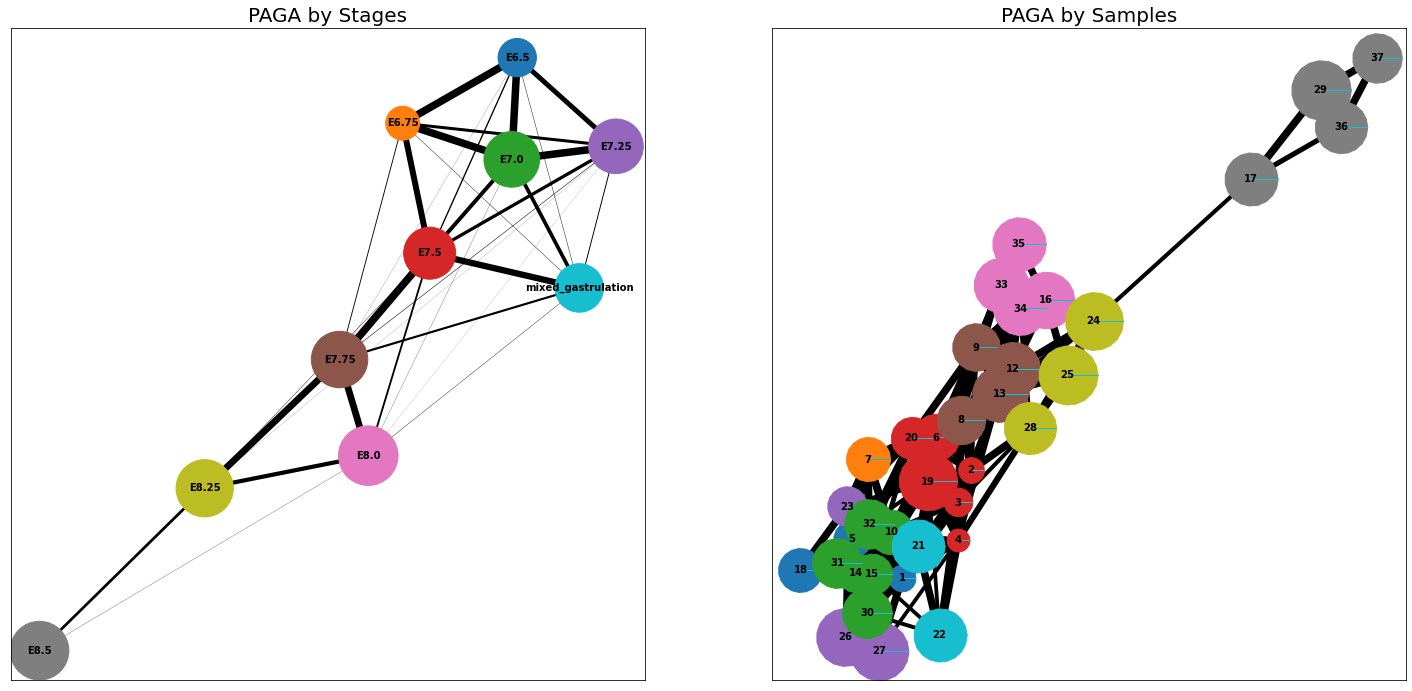

In [5]:
adata.obs["Sample"] = adata.obs["Sample"].astype(str)

fig,ax = plt.subplots(1,2,figsize=[25,12])

scp.tl.paga(adata,groups="Stage")
scp.pl.paga(adata,color="Stage",node_size_scale=20,ax=ax[0],show=False)
ax[0].set_title("PAGA by Stages",fontsize=20)

scp.tl.paga(adata,groups="Sample")
scp.pl.paga(adata,color="Stage",threshold=.5,node_size_scale=20,ax=ax[1],show=False)
ax[1].set_title("PAGA by Samples",fontsize=20)

fig.savefig("./Plots/3_Paga_stages.png",bbox_inches="tight",transparent=True)

# UMAP plot of stages

 We finally, we in a UMAP the integrated dataset. The complexity and density of the data does not allow to see much.

In [6]:
scp.tl.umap(adata)

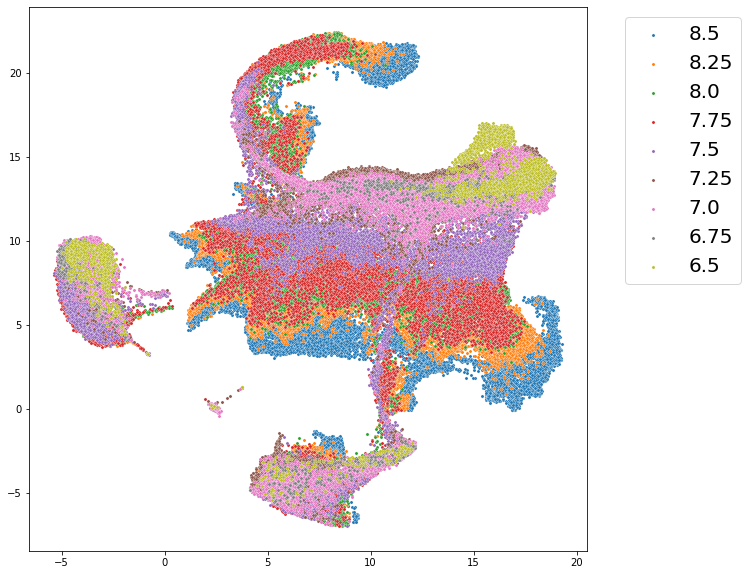

In [7]:
fig,ax=plt.subplots(1,1,figsize=[10,10])

l = adata.obs["Stage"] != "mixed_gastrulation"
for i,stage in enumerate(np.sort(adata.obs["Stage_numeric"].unique())[::-1]):
    l2 = adata.obs["Stage_numeric"] == stage
    l2 = l*l2
    sns.scatterplot(adata.obsm["X_umap"][l2,0],adata.obsm["X_umap"][l2,1],hue_norm=(0,10),s=10,ax=ax)
    
ax.legend(np.sort(adata.obs["Stage_numeric"].unique())[::-1][:-1],fontsize=20,bbox_to_anchor=(1.05, 1))

fig.savefig("./Plots/3_UMAP_integrated.png",bbox_inches="tight",transparent=True)
plt.show()

# Transcriptomical connection between stages

We connect the clusters between stages in fashion very similar to that proposed in [this paper](https://www.nature.com/articles/s41588-022-01018-x).

The connections are made in to manners:

 1. Forward: Gives information of the clusters in a earlier stage to which future clusters provide in the future.
 2. Backward: Gives information of where the clusters in a later stage comes from.

In [8]:
bbknn.bbknn(adata,use_rep="X_pca",batch_key="Stage",n_pcs=N_PCS,metric=METRIC,neighbors_within_batch=N_NEIGBOURS)

In [9]:
def make_edges(a,key_groups="Annotation_Stage",key_batches="Stage_numeric"):

    #Disconnect
    m = pd.DataFrame()

    m["In"] = a.uns["neighbors"]["distances"].nonzero()[0]
    m["Out"] = a.uns["neighbors"]["distances"].nonzero()[1]
    m["Distances"] = np.array(a.uns["neighbors"]["distances"][m["In"],m["Out"]])[0]
    m["Connectivities"] = np.array(a.uns["neighbors"]["connectivities"][m["In"],m["Out"]])[0]
    m["StageIn"] = a.obs.loc[a.obs.iloc[m["In"]].index,key_batches].values
    m["StageOut"] = a.obs.loc[a.obs.iloc[m["Out"]].index,key_batches].values
    m["ClusterIn"] = a.obs.loc[a.obs.iloc[m["In"]].index,key_groups].values
    m["ClusterOut"] = a.obs.loc[a.obs.iloc[m["Out"]].index,key_groups].values

    return m

In [10]:
m = make_edges(adata[adata.obs["Stage"]!="mixed_gastrulation"])

## Forward

In [21]:
l = (m["StageIn"] + .25 < m["StageOut"] ).values
l2 = (m["StageIn"] >= m["StageOut"] ).values
mIn = m.loc[np.invert(l+l2),:]
mIn["ClusterIn"] = mIn["StageIn"].astype(str)+"_"+mIn["ClusterIn"].astype(str)
mIn["ClusterOut"] = mIn["StageOut"].astype(str)+"_"+mIn["ClusterOut"].astype(str)

In [22]:
sIn = mIn.groupby(["ClusterIn","ClusterOut"]).size().unstack()

sIn = sIn.transpose()
sIn = sIn/sIn.sum(axis=0)
sIn = sIn.transpose()

sIn = sIn.fillna(0)
sIn = sIn.transpose()

In [23]:
min_weight = .1

g=igraph.Graph(directed=True)
g.add_vertices(np.unique(np.append(sIn.index.values,sIn.columns.values)))
ed = sIn.unstack().index.values
weight = sIn.unstack().values
ed = ed[weight > min_weight]
weight = weight[weight > min_weight]
g.add_edges(ed,attributes={"weight":weight})

In [24]:
e = pd.DataFrame()
d = g.get_edge_dataframe()
for source in d.loc[:,"source"].unique():
    sb = d[d["source"]==source].sort_values("weight").iloc[0,:]
    e = e.append(sb)
e["source"] = e["source"].astype(int)
e["target"] = e["target"].astype(int)

g_tree = igraph.Graph(directed=True)
g_tree.add_vertices(g.vs["name"])
g_tree.add_edges(e.set_index(["source","target"]).index.values,attributes={"weight":e["weight"].values})

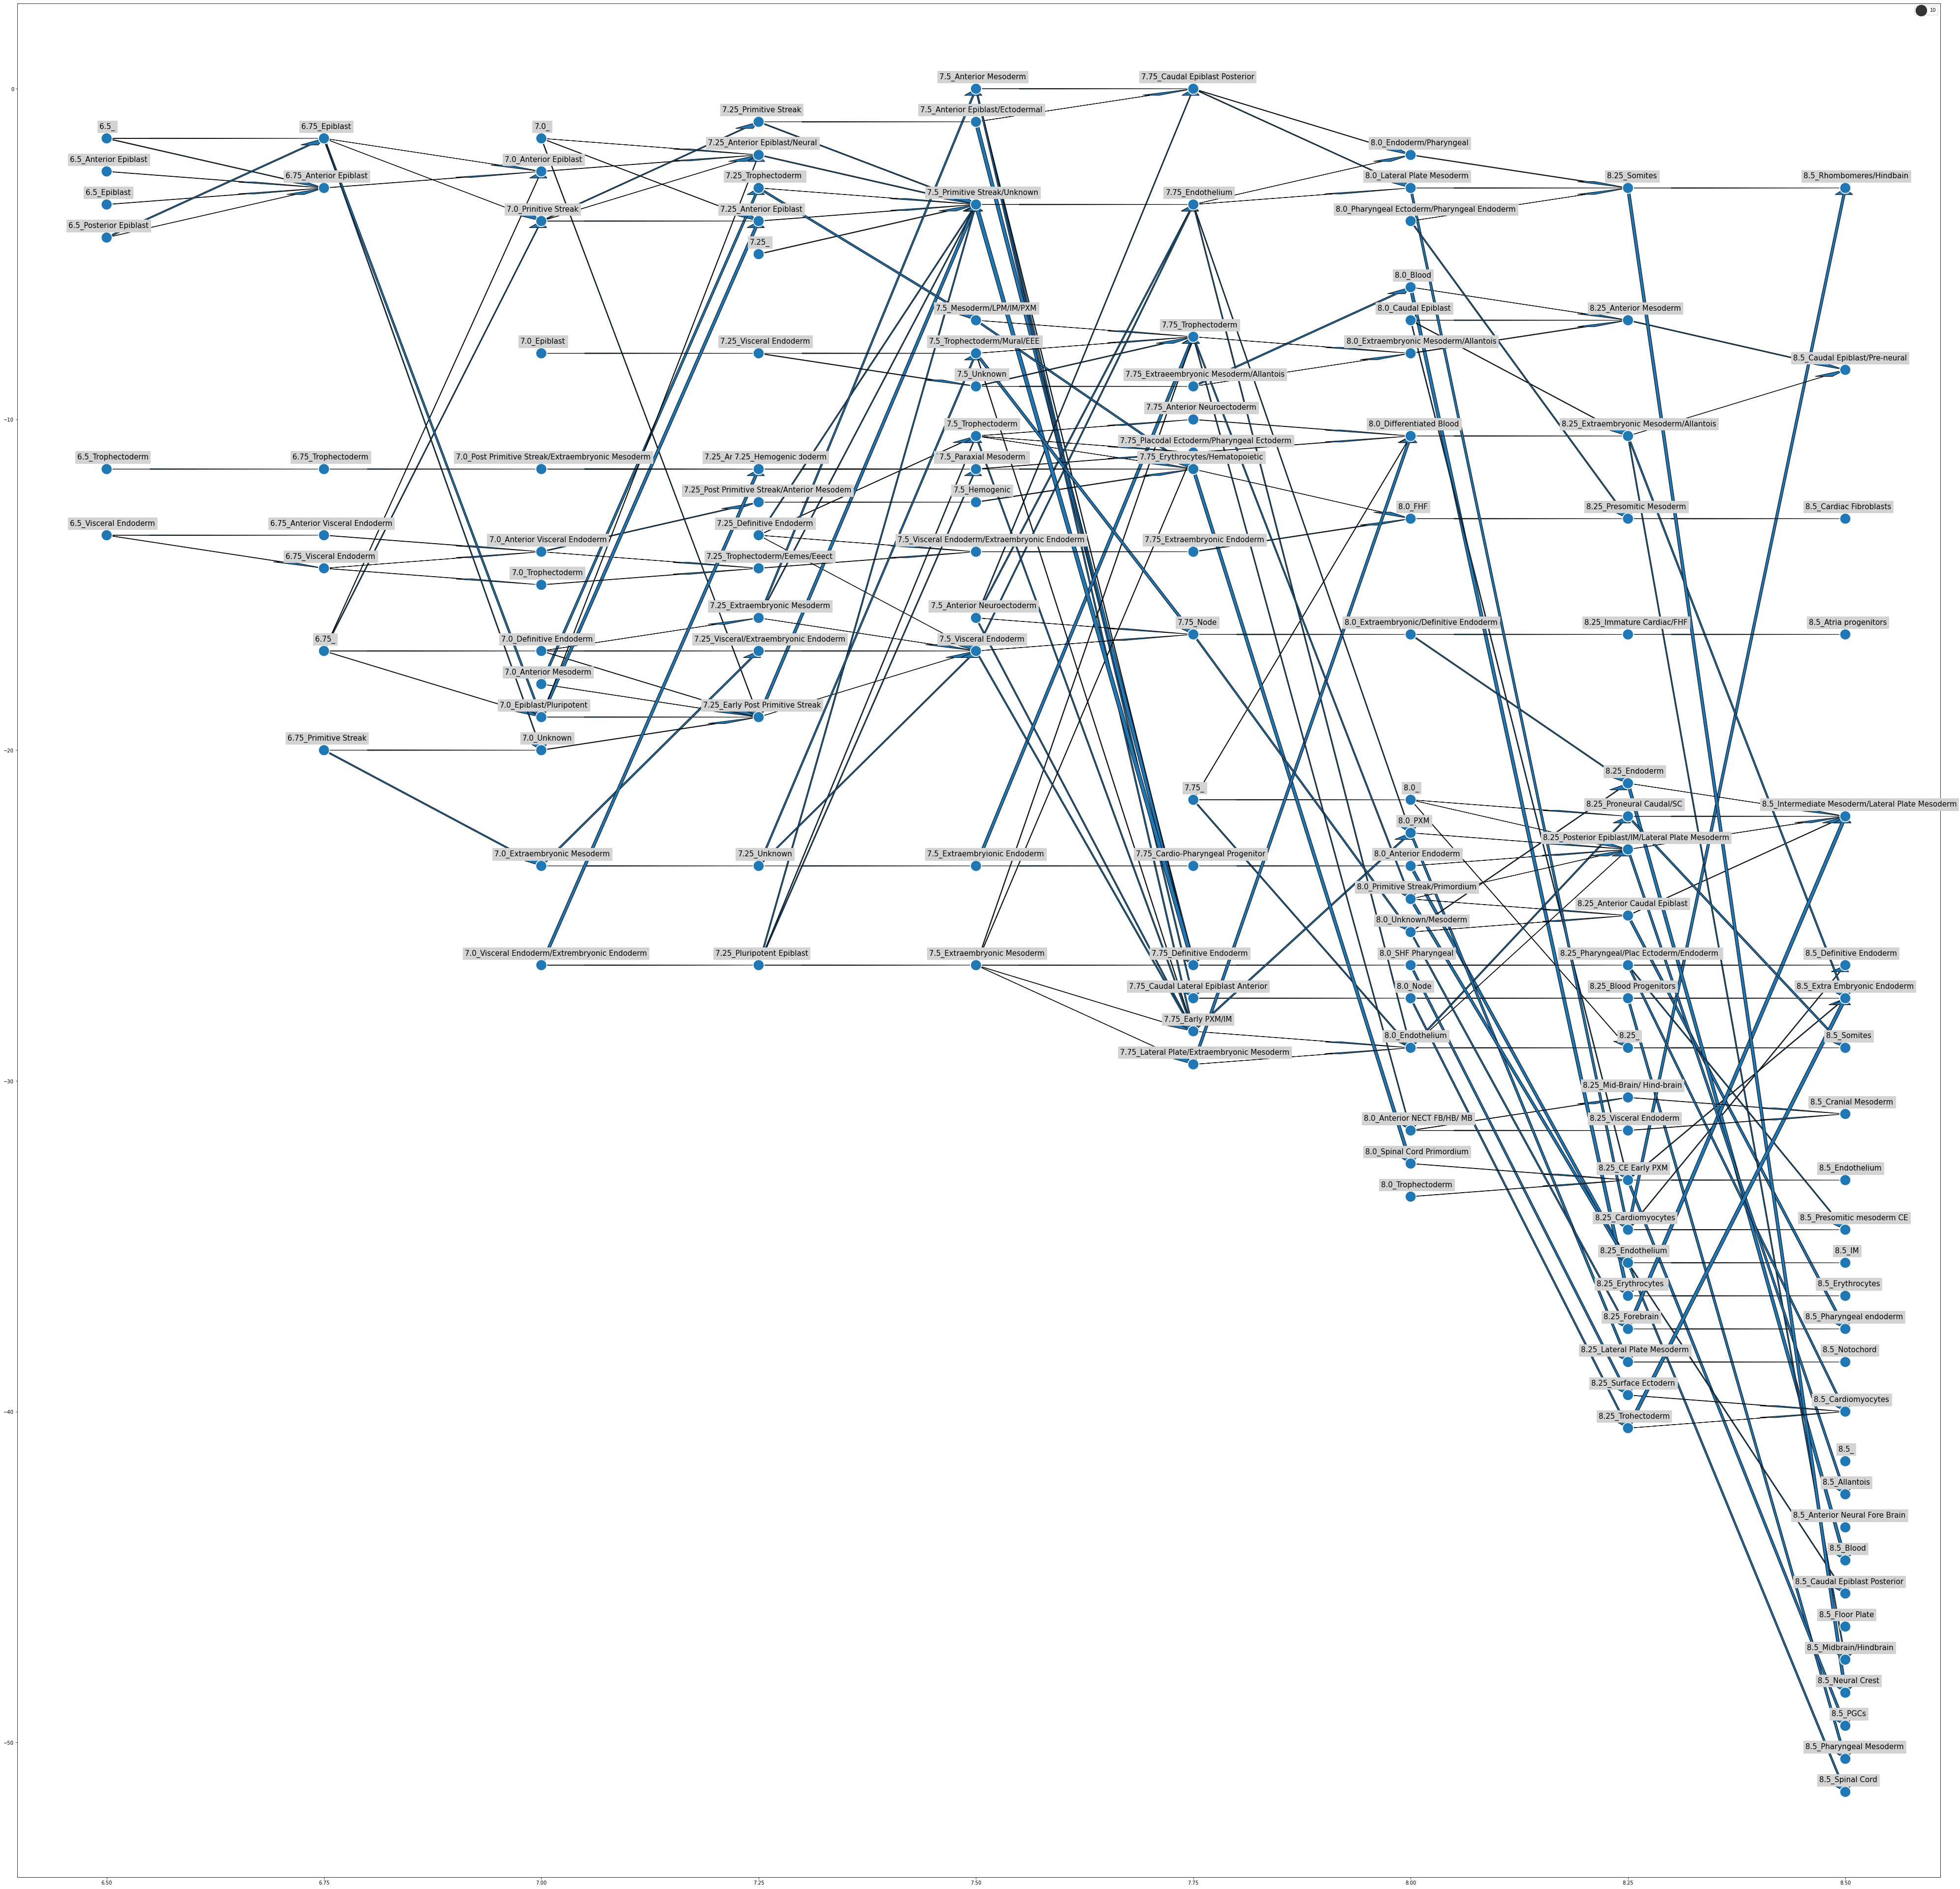

In [25]:
layers = [float(g.vs.find(i)["name"].split("_")[0]) for i in g_tree.vs["name"]]
pos = np.array(g_tree.layout_sugiyama(layers=layers).coords,)
for i in range(len(g.vs)):
    g.vs[i]["label_size"] = 10

fig,ax = plt.subplots(figsize=(70,70))
#c = [float(i[1:].split("_")[0]) for i in g.get_vertex_dataframe()["name"].values]
#ann = g.get_vertex_dataframe()["name"].values
sns.scatterplot(x=pos[:,1],y=-pos[:,0],size=10,sizes=(500,500),ax=ax)

for i,n in enumerate(g.vs["name"]):
    ax.text(pos[i,1]-.002*len(n),-pos[i,0]+.3,n,fontsize=15,backgroundcolor="lightgrey")

for n,w in zip(g.get_edgelist(),g.get_edge_dataframe()["weight"].values):
    ax.arrow(pos[n[0],1],-pos[n[0],0],pos[n[1],1]-pos[n[0],1],-pos[n[1],0]+pos[n[0],0],
             head_width=.02,head_length=.2,width=0.005*w,
             length_includes_head=True,zorder=-1)

fig.savefig("Plots/3_Forward_edges.pdf",bbox_inches="tight")

## Backward

In [26]:
l = (m["StageIn"] - .25 > m["StageOut"] ).values
l2 = (m["StageIn"] <= m["StageOut"] ).values
mIn = m.loc[np.invert(l+l2),:]
mIn["ClusterIn"] = mIn["StageIn"].astype(str)+"_"+mIn["ClusterIn"].astype(str)
mIn["ClusterOut"] = mIn["StageOut"].astype(str)+"_"+mIn["ClusterOut"].astype(str)

In [27]:
sIn = mIn.groupby(["ClusterIn","ClusterOut"]).size().unstack()

sIn = sIn.transpose()
sIn = sIn/sIn.sum(axis=0)
sIn = sIn.transpose()

sIn = sIn.fillna(0)
sIn = sIn.transpose()

In [28]:
min_weight = .1

g=igraph.Graph(directed=True)
g.add_vertices(np.unique(np.append(sIn.index.values,sIn.columns.values)))
ed = sIn.unstack().index.values
weight = sIn.unstack().values
ed = ed[weight > min_weight]
weight = weight[weight > min_weight]
g.add_edges(ed,attributes={"weight":weight})

In [29]:
e = pd.DataFrame()
d = g.get_edge_dataframe()
for source in d.loc[:,"source"].unique():
    sb = d[d["source"]==source].sort_values("weight").iloc[0,:]
    e = e.append(sb)
e["source"] = e["source"].astype(int)
e["target"] = e["target"].astype(int)

g_tree = igraph.Graph(directed=True)
g_tree.add_vertices(g.vs["name"])
g_tree.add_edges(e.set_index(["source","target"]).index.values,attributes={"weight":e["weight"].values})

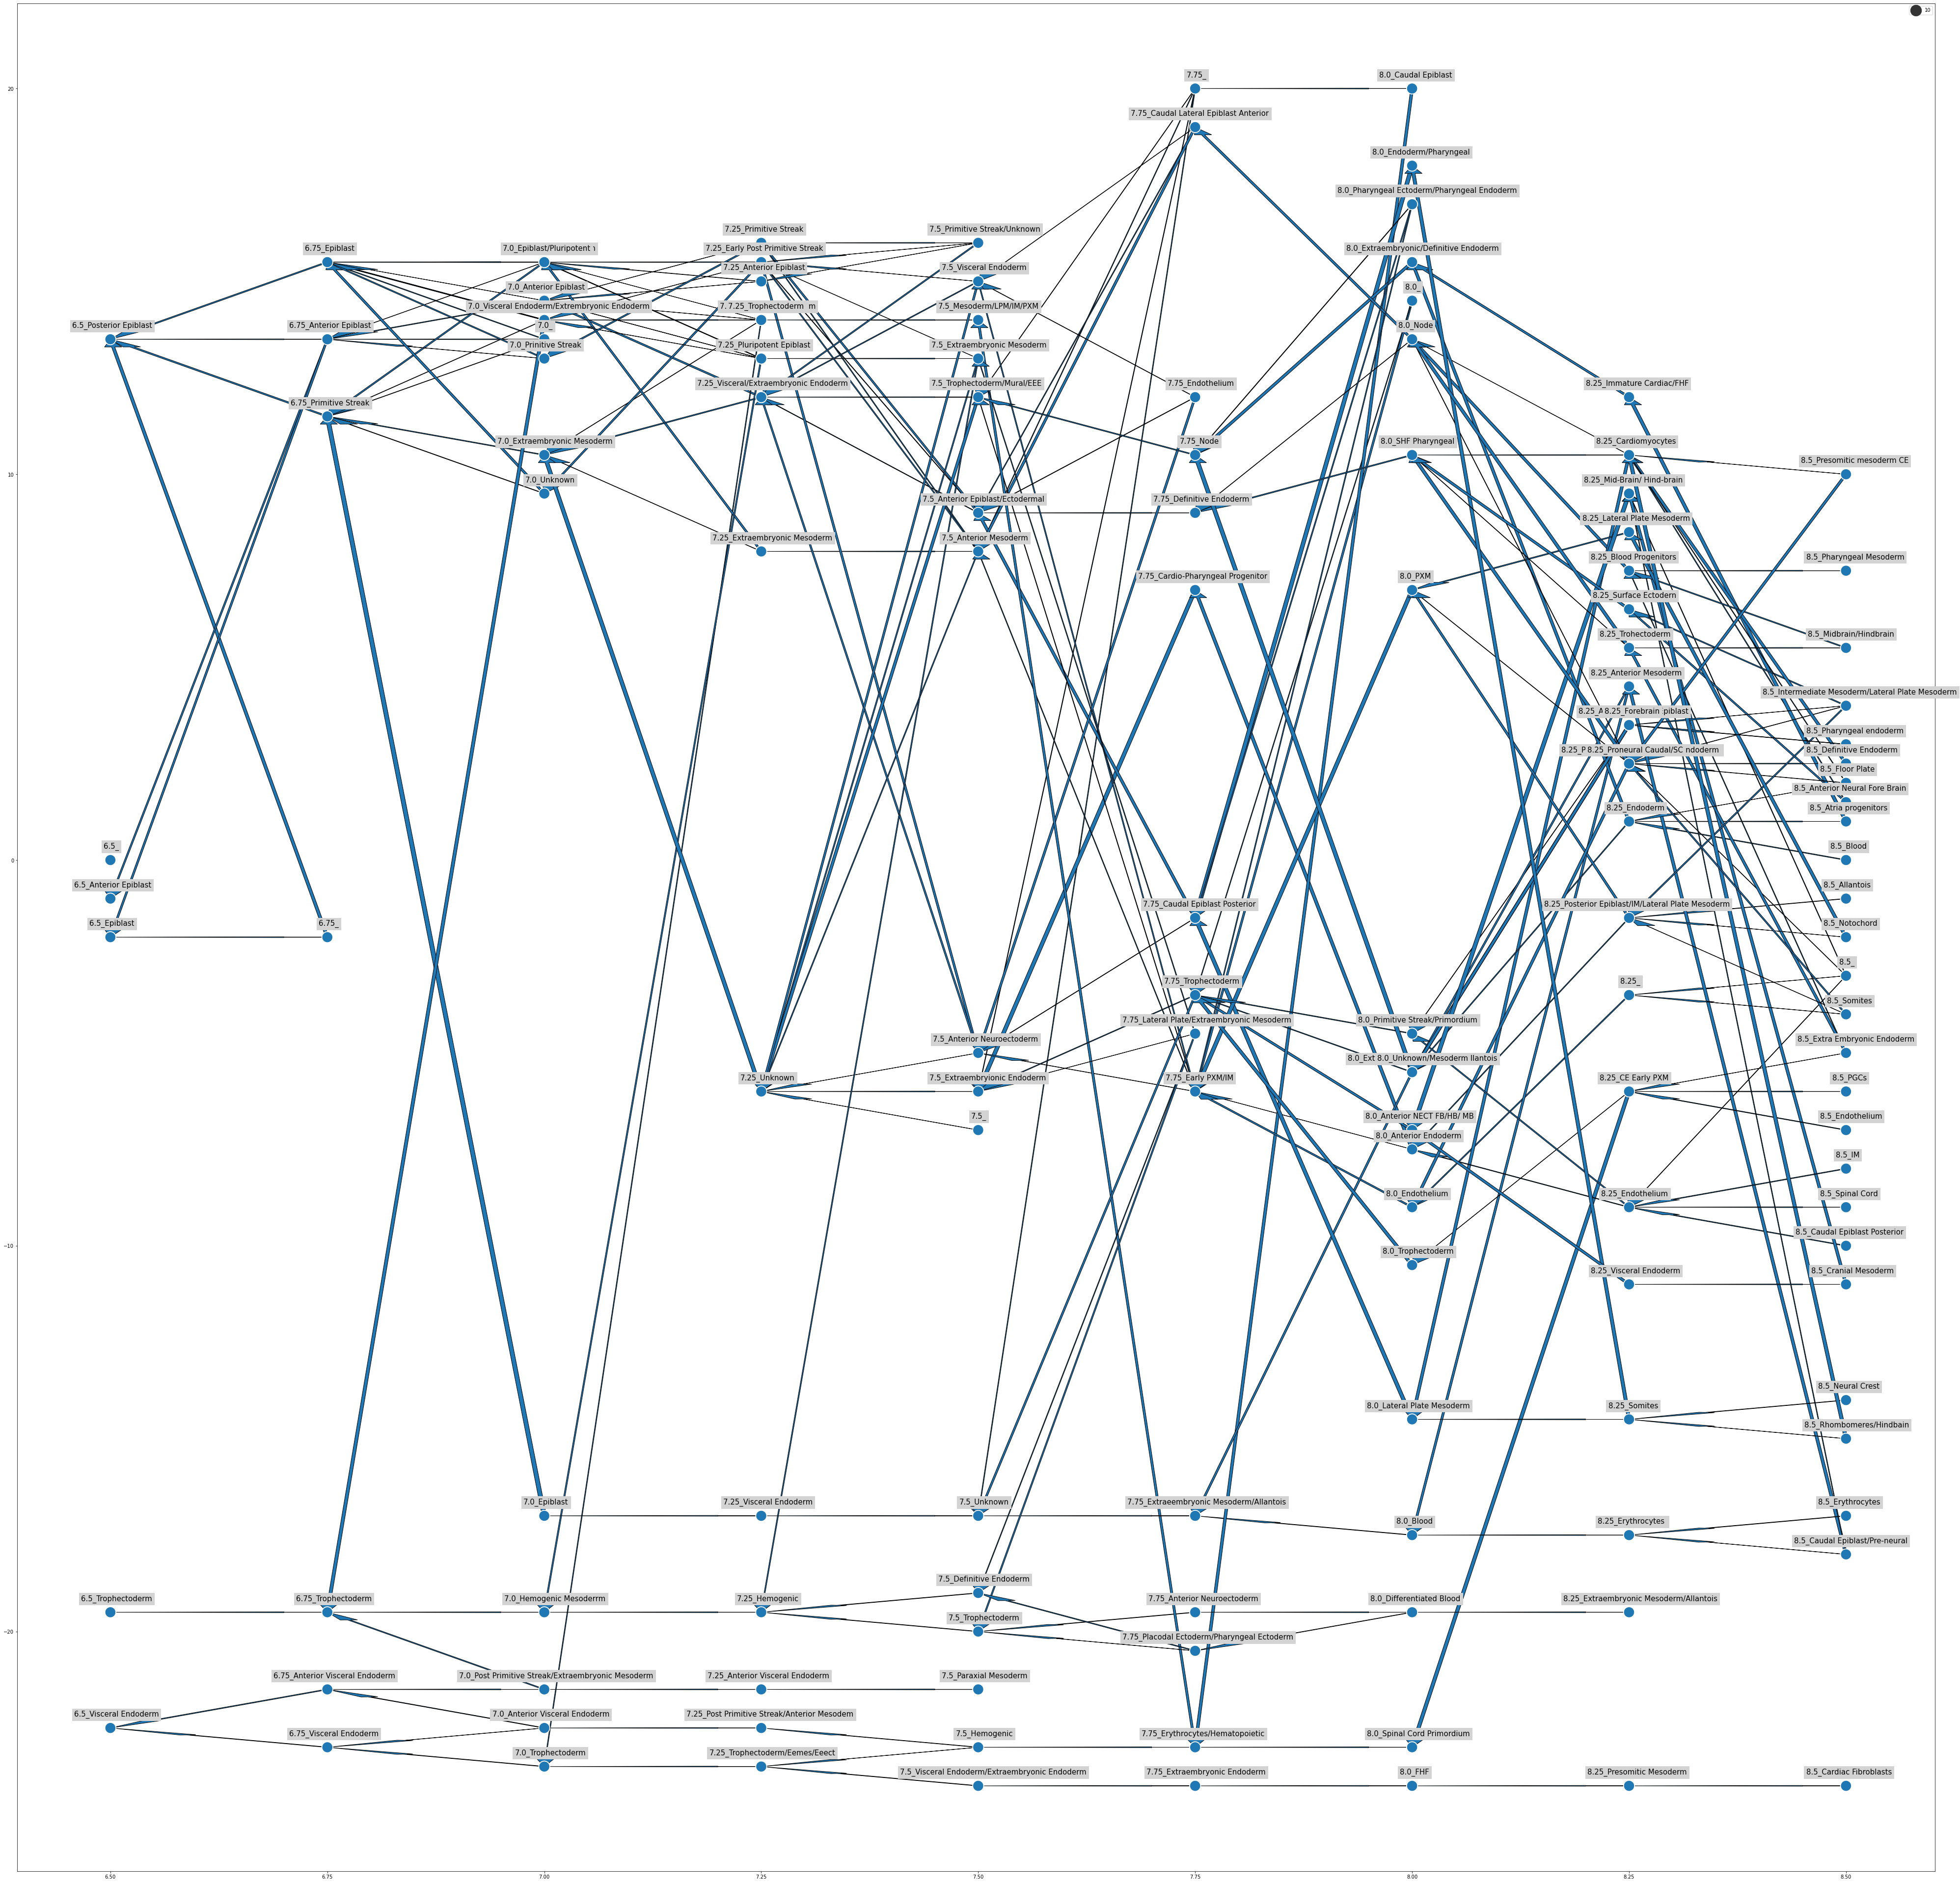

In [30]:
layers = [float(g.vs.find(i)["name"].split("_")[0]) for i in g_tree.vs["name"]]
pos = np.array(g_tree.layout_sugiyama(layers=layers).coords,)
for i in range(len(g.vs)):
    g.vs[i]["label_size"] = 10

fig,ax = plt.subplots(figsize=(70,70))
#c = [float(i[1:].split("_")[0]) for i in g.get_vertex_dataframe()["name"].values]
#ann = g.get_vertex_dataframe()["name"].values
sns.scatterplot(x=pos[:,1],y=-pos[:,0],size=10,sizes=(500,500),ax=ax)

for i,n in enumerate(g.vs["name"]):
    ax.text(pos[i,1]-.002*len(n),-pos[i,0]+.3,n,fontsize=15,backgroundcolor="lightgrey")

for n,w in zip(g.get_edgelist(),g.get_edge_dataframe()["weight"].values):
    ax.arrow(pos[n[0],1],-pos[n[0],0],pos[n[1],1]-pos[n[0],1],-pos[n[1],0]+pos[n[0],0],
             head_width=.02,head_length=.2,width=0.005*w,
             length_includes_head=True,zorder=-1)

fig.savefig("Plots/3_Backward_edges.pdf",bbox_inches="tight")